# PPO
PPO与TRPO的动机相同：在使用当前数据的情况下，我们如何能够在策略上迈出尽可能大的改进步骤，而不会走得太远以至于意外地导致性能崩溃？

TRPO尝试通过复杂的二阶方法解决这个问题，而PPO是一阶方法，使用一些其他技巧来确保新策略接近旧策略。

PPO方法在实施上显著简单，并且经验证实际上至少与TRPO一样表现良好。

有两个主要的PPO变体：**PPO-Penalty**和**PPO-Clip**。

## PPO-Penalty
**PPO-Penalty**大致上解决了像TRPO一样的KL受限更新，但是在目标函数中对KL散度进行惩罚，而不是将其作为硬约束，并且在训练过程中自动调整惩罚系数，以便适当地进行缩放。

## PPO-Clip
**PPO-Clip**在目标函数中没有KL散度项，也没有任何约束。相反，它依赖于目标函数中的专门剪切，以消除新策略远离旧策略的动机。

## 小结
- PPO 是一种同策略算法
- PPO 可用于离散或连续空间的环境
- Spinning Up实现的PPO支持使用MPI进行并行化。

# 数学解释
PPO-Clip通过以下方式更新策略：

$$\theta_{k+1} = \arg \max_{\theta} \underset{s,a \sim \pi_{\theta_k}}{\mathbb{E}}\left[ L(s,a,\theta_k, \theta)\right],$$

通常采用**多步（通常是小批量）SGD**来最大化这个目标。其中，$L$由以下公式给出：

$$L(s,a,\theta_k,\theta) = \min\left( \frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)} A^{\pi_{\theta_k}}(s,a), \;\; \text{clip}\left(\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}, 1 - \epsilon, 1+\epsilon \right) A^{\pi_{\theta_k}}(s,a) \right),$$

其中 $\epsilon$ 是一个（较小的）超参数，大致表示**新策略允许离旧策略有多远**。

这是一个相当复杂的表达式，一眼看上去很难理解它在做什么，或者它如何帮助保持新策略接近旧策略。

事实上，这个目标函数有一个[相当简化的版本](https://drive.google.com/file/d/1PDzn9RPvaXjJFZkGeapMHbHGiWWW20Ey/view "请查看有关PPO-Clip目标简化形式推导的说明。")，稍微容易理解一些（也是我们在代码中实现的版本）：

$$L(s,a,\theta_k,\theta) = \min\left( \frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)} A^{\pi_{\theta_k}}(s,a), \;\; g(\epsilon, A^{\pi_{\theta_k}}(s,a)) \right),$$

其中

$$g(\epsilon, A) = \left\{ \begin{array}{ll} (1 + \epsilon) A & A \geq 0 \\ (1 - \epsilon) A & A < 0. \end{array} \right.$$

为了理解这个表达式背后的直觉，让我们看一个单独的状态动作对$(s,a)$，并思考不同的情况。

当**优势是正值**时：假设该状态-动作对的优势为正值，那么其对目标的贡献就变为

$$L(s,a,\theta_k,\theta) = \min\left( \frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}, (1 + \epsilon) \right) A^{\pi_{\theta_k}}(s,a).$$

因为优势是正值，如果动作变得更有可能发生——即，如果 $\pi_{\theta}(a|s)$ 增加，目标将增加。但是，在这个项中的 min 函数对目标增加的幅度进行了限制。

一旦 $\pi_{\theta}(a|s) > (1+\epsilon) \pi_{\theta_k}(a|s)$，min 函数会生效，该项就达到了 $(1+\epsilon) A^{\pi_{\theta_k}}(s,a)$ 的上限。

因此：新策略不会受益于远离旧策略太远。

优势为负值时：假设该状态-动作对的优势为负值，那么其对目标的贡献就变为

$$L(s,a,\theta_k,\theta) = \max\left( \frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}, (1 - \epsilon) \right) A^{\pi_{\theta_k}}(s,a).$$

因为优势是负值，如果动作变得不太可能发生——即，如果 $\pi_{\theta}(a|s)$ 减小，目标将增加。但是，在这个项中的 max 函数对目标增加的幅度进行了限制。

一旦 $\pi_{\theta}(a|s) < (1-\epsilon) \pi_{\theta_k}(a|s)$，max 函数会生效，该项就达到了 $(1-\epsilon) A^{\pi_{\theta_k}}(s,a)$ 的上限。

因此，再次强调：新策略不会受益于远离旧策略太远。

<div align=center>
<img width="550" src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*MpPiARNoNGCxJE2a8m9itA.png "/>
</div>
<div align=center></div>

到目前为止，我们看到剪切作为正则化器，通过消除使策略发生显著变化的动机，而超参数 $\epsilon$ 对应于新策略可以离旧策略多远而仍然对目标有利。

>尽管这种剪切方法在很大程度上确保了合理的策略更新，但仍然有可能得到一个与旧策略相距太远的新策略。
>不同的PPO实现使用了许多技巧来防止这种情况发生。
>在我们这里的实现中，我们采用了一种特别简单的方法：**提前停止**。
>**如果新策略与旧策略之间的平均KL散度超过了阈值，我们就停止梯度更新步骤**。

# 探索与利用

PPO以在线方式训练随机策略。

这意味着它**通过根据其随机策略的最新版本对动作进行采样来进行探索**。动作选择中的随机性程度取决于初始条件和训练过程。

随着训练的进行，随着更新规则鼓励策略利用已经发现的奖励，策略通常会逐渐变得不太随机。这可能导致策略被困在**局部最优解中**。

# 伪代码
PPO-Clip：

输入：初始策略参数 $\theta_0$，初始值函数参数 $\phi_{0}$

1. for $k=0,1,2,...$ do
    1. 运行策略 $\pi_k=\pi(\theta_k)$ 在环境中，收集轨迹集合 $D_k=\{\tau_i\}$
    2. 计算回报至终点 $\hat{R}_t.$
    3. 基于当前值函数 $V_\mathrm{\phi k}$，计算优势估计 $\hat{A}_t$（使用任何优势估计方法）。
    4. 通过最大化 PPO-Clip 目标更新策略：
       $$\theta_{k+1}=\arg\max_{\theta}\frac{1}{|\mathcal{D}_{k}|T}\sum_{\tau\in\mathcal{D}_{k}}\sum_{t=0}^{T}\min\left(\frac{\pi_{\theta}(a_{t}|s_{t})}{\pi_{\theta_{k}}(a_{t}|s_{t})}\hat{A}^{\pi_{\theta}}(s_{t},a_{t}),\:g(\epsilon,\hat{A}^{\pi_{\theta}}_{k}(s_{t},a_{t}))\right),$$
   通常使用 Adam 随机梯度上升法。

    6. 通过均方误差回归拟合值函数：
       $$\phi_{k+1}=\arg\min_{\phi}\frac{1}{|\mathcal{D}_{k}|T}\sum_{\tau\in\mathcal{D}_{k}}\sum_{t=0}^{T}\left(V_{\phi}(s_{t})-\hat{R}_{t}\right)^{2},$$
       通常使用某种梯度下降算法。

2. end for

# 经验
1. PPO在稀疏奖励下，表现可能不佳
    1. MountainCar-v0

## 智能体
### 根据输入状态选择动作
1. 将输入状态转换为 PyTorch 浮点型张量并发送到指定设备。
   ```python
   s = torch.from_numpy(s).float().to(self.dvc)
   ```
3. 使用训练好的 actor 模型获取动作概率分布。
    ```python
    pi = self.actor.pi(s, softmax_dim=0)
    ```
4. 如果 `1deterministic` 为 True，选择概率最高的动作。
    ```python
    a = torch.argmax(pi).item()
    return a, None
    ```
5. 如果 `deterministic` 为 False，从概率分布中采样一个动作，并返回该动作及其对数概率。
    ```python
    m = Categorical(pi)  # 使用分类分布构建采样器
    a = m.sample().item()  # 从分布中采样一个动作
    pi_a = pi[a].item()  # 获取选择动作的对数概率
    return a, pi_a
    ```

### 训练
1. 执行 PPO 算法的训练过程。
    1. exploration decay：更新探索参数 entropy_coef。
       ```python
       # 更新熵系数，乘以熵系数衰减率
       self.entropy_coef *= self.entropy_coef_decay
       ```
       
    2. 准备 PyTorch 数据：将经验数据转换为 PyTorch 张量，并发送到指定设备。
       ```python
       # 将存储的环境状态、动作、奖励、下一个状态、动作的对数概率、完成标志以及权重转换为PyTorch张量，并发送到指定设备
       s = torch.from_numpy(self.s_hoder).to(self.dvc)  # 当前状态
       a = torch.from_numpy(self.a_hoder).to(self.dvc)  # 动作
       r = torch.from_numpy(self.r_hoder).to(self.dvc)  # 奖励
       s_next = torch.from_numpy(self.s_next_hoder).to(self.dvc)  # 下一个状态
       old_prob_a = torch.from_numpy(self.logprob_a_hoder).to(self.dvc)  # 动作的对数概率
       done = torch.from_numpy(self.done_hoder).to(self.dvc)  # 完成标志
       dw = torch.from_numpy(self.dw_hoder).to(self.dvc)  # 权重
       ```
       
    3. 使用 **TD+GAE+LongTrajectory** 方法计算 Advantage 和 TD 目标。
        1. 获取当前状态值 vs 和下一个状态值 vs_。
            ```PYTHON
            # 计算当前状态的值函数 vs 和下一个状态的值函数 vs_
            vs = self.critic(s)
            vs_ = self.critic(s_next)
            ```
            
        2. 计算 deltas（TD error）= r + gamma * vs_ * (~dw) - vs。
            ```PYTHON
            # 使用torch.no_grad()上下文，禁用梯度计算以提高计算效率
            with torch.no_grad():
                # 计算当前状态的值函数 vs 和下一个状态的值函数 vs_
                vs = self.critic(s)
                vs_ = self.critic(s_next)

                # 计算时序差分误差（deltas），考虑奖励、折扣因子、下一个状态值函数、权重和完成标志
                deltas = r + self.gamma * vs_ * (~dw) - vs
                # 将时序差分误差转换为NumPy数组
                deltas = deltas.cpu().flatten().numpy()
                # 初始化优势列表，初始值为0
                adv = [0]
            ```
            
        5. 计算 Advantage，使用 GAE 方法考虑长时间轨迹。
            ```PYTHON
            # 通过反向迭代计算优势（advantage）
            for dlt, done in zip(deltas[::-1], done.cpu().flatten().numpy()[::-1]):
                # 计算当前时间步的优势，考虑时序差分误差、折扣因子、权重和完成标志
                advantage = dlt + self.gamma * self.lambd * adv[-1] * (~done)
                # 将计算得到的优势添加到优势列表
                adv.append(advantage)
            # 反转优势列表，以保持正确的时间顺序
            adv.reverse()

            # 剔除优势列表的最后一个元素，以去除冗余添加的初始值
            adv = copy.deepcopy(adv[0:-1])
            # 将优势列表转换为PyTorch张量，并进行形状调整
            adv = torch.tensor(adv).unsqueeze(1).float().to(self.dvc)
            ```
        7. 计算 TD 目标，td_target = adv + vs。
            ```PYTHON
            # 计算时序差分目标（td_target）
            td_target = adv + vs
            ```
        9. 如果开启 Advantage normalization，则对 Advantage 进行标准化。
            ```PYTHON
            # 如果启用了优势归一化，对优势进行归一化处理
            if self.adv_normalization:
                # 计算优势的均值和标准差，并进行归一化处理
                adv = (adv - adv.mean()) / ((adv.std() + 1e-4))
            ```

    6. PPO 更新：执行多次 PPO 更新，每次包括 actor 和 critic 的更新。
       
        1. Slice long trajectory：将长时间轨迹切分为短时间轨迹，以执行小批量 PPO 更新。
            ```PYTHON
            # 计算优化迭代次数，确保能够处理所有样本
            optim_iter_num = int(math.ceil(s.shape[0] / self.batch_size))
            ```
        3. 循环执行 PPO 更新过程。
            1. Shuffle trajectory：对轨迹进行随机排列，以改善训练效果。
                ```PYTHON
                # 迭代执行多个优化步骤（K_epochs次）
                for _ in range(self.K_epochs):
                # 随机打乱样本索引的顺序
                perm = np.arange(s.shape[0])
                np.random.shuffle(perm)
                # 将打乱后的索引转换为PyTorch张量并发送到指定设备
                perm = torch.LongTensor(perm).to(self.dvc)

                # 根据打乱后的索引重新排列数据，使用深度复制以避免原始数据被修改
                s, a, td_target, adv, old_prob_a = \
                    s[perm].clone(), a[perm].clone(), td_target[perm].clone(), adv[perm].clone(), old_prob_a[perm].clone()
                ```
            2. Mini-batch PPO update：对每个 mini-batch 执行 PPO 更新。
                ```PYTHON
                # 遍历每个优化迭代
                for i in range(optim_iter_num):
                    # 确定当前迭代的样本索引范围
                    index = slice(i * self.batch_size, min((i + 1) * self.batch_size, s.shape[0]))
                ```
                - Actor 更新：
                    - 获取 actor 输出的动作概率分布 prob。
                      ```PYTHON
                      prob = self.actor.pi(s[index], softmax_dim=1)
                      ```
                    - 计算 entropy。
                      ```PYTHON
                      entropy = Categorical(prob).entropy().sum(0, keepdim=True)
                      ```
                    - 获取选择动作的对数概率 prob_a。
                      ```python
                      prob_a = prob.gather(1, a[index])
                      ```
                    - 计算 PPO 损失 a_loss。
                      ```PYTHON
                      # 计算新概率与旧概率的比率
                      ratio = torch.exp(torch.log(prob_a) - torch.log(old_prob_a[index]))
                      # 计算Clipped Surrogate函数的第一部分
                      surr1 = ratio * adv[index]
                      # 计算Clipped Surrogate函数的第二部分，使用torch.clamp函数将比率限制在[1 - clip_rate, 1 + clip_rate]范围内
                      surr2 = torch.clamp(ratio, 1 - self.clip_rate, 1 + self.clip_rate) * adv[index]
                      # 计算Actor的损失，包括负的Clipped Surrogate函数最小值和熵正则项
                      a_loss = -torch.min(surr1, surr2) - self.entropy_coef * entropy
                      ```
                    - 使用反向传播和梯度裁剪更新 actor 模型参数。
                      ```PYTHON
                      # 将Actor的梯度置零，以防止梯度累积
                      self.actor_optimizer.zero_grad()
                      # 计算Actor的损失对参数的梯度
                      a_loss.mean().backward()
                      # 使用梯度裁剪，防止梯度爆炸
                      torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 40)
                      # 更新Actor的参数，执行一步优化器
                      self.actor_optimizer.step()
                      ```
                - Critic 更新：
                    - 计算 critic 的损失 c_loss。
                      ```PYTHON
                      # 计算均方误差损失，即Critic网络输出值与目标值的差的平方的均值
                      c_loss = (self.critic(s[index]) - td_target[index]).pow(2).mean()
                      ```
                    - 添加 L2 正则化项（如果设置了 l2_reg）。
                      ```PYTHON
                      # 添加L2正则项，对Critic的权重参数进行平方求和，并乘以L2正则化系数self.l2_reg
                      for name, param in self.critic.named_parameters():
                          if 'weight' in name:
                              c_loss += param.pow(2).sum() * self.l2_reg
                      ```
                    - 使用反向传播更新 critic 模型参数。
                      ```PYTHON
                      # 对Critic进行梯度清零，计算梯度，更新参数
                      self.critic_optimizer.zero_grad()
                      c_loss.backward()
                      self.critic_optimizer.step()
                      ```

### 存储经验数据
将每个时间步的经验数据存储到相应的缓存数组中，以便后续的训练过程使用。
```python
def put_data(self, s, a, r, s_next, logprob_a, done, dw, idx):
    """
    存储经验数据到对应的缓存中

    参数:
    - s: 当前状态
    - a: 采取的动作
    - r: 获得的奖励
    - s_next: 下一个状态
    - logprob_a: 采取动作的对数概率
    - done: 是否完成当前 episode
    - dw: 重要性采样权重
    - idx: 存储的索引位置
    """
    self.s_hoder[idx] = s  # 存储当前状态到状态缓存中
    self.a_hoder[idx] = a  # 存储采取的动作到动作缓存中
    self.r_hoder[idx] = r  # 存储获得的奖励到奖励缓存中
    self.s_next_hoder[idx] = s_next  # 存储下一个状态到下一个状态缓存中
    self.logprob_a_hoder[idx] = logprob_a  # 存储采取动作的对数概率到对数概率缓存中
    self.done_hoder[idx] = done  # 存储是否完成当前 episode 到完成标志缓存中
    self.dw_hoder[idx] = dw  # 存储重要性采样权重到权重缓存中
```

### 保存当前训练模型
保存当前训练模型的Actor和Critic参数到文件
```python
def put_data(self, s, a, r, s_next, logprob_a, done, dw, idx):
    """
    将经验数据存储到缓存中

    参数:
    - s: 当前状态
    - a: 采取的动作
    - r: 获得的奖励
    - s_next: 下一个状态
    - logprob_a: 采取动作的对数概率
    - done: 是否完成当前 episode
    - dw: 重要性采样权重
    - idx: 存储索引

    说明:
    将每个时间步的经验数据存储到相应的缓存数组中，以便后续的训练过程使用。
    """
    self.s_hoder[idx] = s  # 存储当前状态到状态缓存中
    self.a_hoder[idx] = a  # 存储采取的动作到动作缓存中
    self.r_hoder[idx] = r  # 存储获得的奖励到奖励缓存中
    self.s_next_hoder[idx] = s_next  # 存储下一个状态到下一个状态缓存中
    self.logprob_a_hoder[idx] = logprob_a  # 存储采取动作的对数概率到对数概率缓存中
    self.done_hoder[idx] = done  # 存储是否完成当前 episode 到完成标志缓存中
    self.dw_hoder[idx] = dw  # 存储重要性采样权重到权重缓存中
```

### 加载模型
```python
def load(self, episode):
    """
    加载之前保存的 Critic 和 Actor 模型参数

    参数:
    - episode: 需要加载的模型参数所对应的训练 episode 数

    说明:
    1. 从指定路径加载之前保存的 Critic 模型参数。
    2. 从指定路径加载之前保存的 Actor 模型参数。
    """
    # 加载之前保存的 Critic 的参数
    self.critic.load_state_dict(torch.load("./model/ppo_critic{}.pth".format(episode)))
    # 加载之前保存的 Actor 的参数
    self.actor.load_state_dict(torch.load("./model/ppo_actor{}.pth".format(episode)))
```

# 代码
## 超参数

In [1]:
from utils import evaluate_policy, str2bool, test_policy
from datetime import datetime
import gymnasium as gym
import os, shutil
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter
import random
import numpy as np
import copy
import math
from collections import deque

In [2]:
def get_args():
    # 创建命令行参数解析器
    parser = argparse.ArgumentParser()

    # 添加各种命令行参数
    parser.add_argument('--algo_name',default='PPO',type=str,help="算法名")
    parser.add_argument('--dvc', type=str, default='cuda', help='运行设备: cuda 或 cpu')
    parser.add_argument('--env_name', type=str, default='CartPole-v1', help='环境名')
    parser.add_argument('--render_mode', type=str, default='rgb_array', help='环境渲染模式')
    parser.add_argument('--write', type=str2bool, default=True, help='使用SummaryWriter记录训练')
    parser.add_argument('--render', type=str2bool, default=False, help='是否渲染')
    parser.add_argument('--Loadmodel', type=str2bool, default=False, help='是否加载预训练模型')
    parser.add_argument('--ModelIdex', type=int, default=100000, help='要加载的模型索引')
    parser.add_argument('--deque_maxlen',default=10,type=int)

    parser.add_argument('--seed', type=int, default=1, help='随机种子')
    parser.add_argument('--T_horizon', type=int, default=500, help='长轨迹的长度')
    parser.add_argument('--Max_train_steps', type=int, default=5e7, help='最大训练步数')
    parser.add_argument('--save_interval', type=int, default=1e5, help='模型保存间隔，以步为单位')
    parser.add_argument('--eval_interval', type=int, default=2e3, help='模型评估间隔，以步为单位')
    parser.add_argument('--test_interval', type=int, default=1e5, help='视频保存间隔，以步为单位')

    parser.add_argument('--gamma', type=float, default=0.99, help='折扣因子')
    parser.add_argument('--lambd', type=float, default=0.95, help='GAE因子')
    parser.add_argument('--clip_rate', type=float, default=0.2, help='PPO剪切率')
    parser.add_argument('--K_epochs', type=int, default=20, help='PPO更新次数')
    parser.add_argument('--net_width', type=int, default=256, help='隐藏网络宽度')
    parser.add_argument('--lr', type=float, default=2e-4, help='学习率')
    parser.add_argument('--l2_reg', type=float, default=0, help='Critic的L2正则化系数')
    parser.add_argument('--batch_size', type=int, default=64, help='切片轨迹的长度')
    parser.add_argument('--entropy_coef', type=float, default=0, help='Actor的熵系数')
    parser.add_argument('--entropy_coef_decay', type=float, default=0.99, help='熵系数的衰减率')
    parser.add_argument('--adv_normalization', type=str2bool, default=False, help='优势值正则化')
    
    # 解析命令行参数
    args = parser.parse_args([])
    args = {**vars(args)}  # 转换成字典类型    
    
    return args

In [3]:
def print_args(args):
    ## 打印超参数
    print("超参数")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k,v in args.items():
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))  

## 网络搭建

In [4]:
def init_weight(m):
    """
    初始化神经网络模型权重的函数

    参数:
    - m: 神经网络模型的模块

    说明:
    1. 判断模块是否为线性层（nn.Linear）。
    2. 如果是线性层，使用 Xavier 正态分布初始化权重，偏置初始化为零。
    """
    if isinstance(m, nn.Linear):  # 判断模块是否为线性层
        nn.init.xavier_normal_(m.weight)  # 使用 Xavier 正态分布初始化权重
        nn.init.constant_(m.bias, 0.0)  # 偏置初始化为零

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, net_width):
        """
        Actor 神经网络模型

        参数:
        - state_dim: 输入状态的维度
        - action_dim: 输出动作的维度
        - net_width: 神经网络的宽度

        说明:
        1. 定义三个全连接层，分别是输入层、隐藏层1和隐藏层2。
        2. 输出层是动作的维度。

        注意:
        - forward 方法用于前向传播，pi 方法用于获取动作的概率分布。
        """
        super(Actor, self).__init__()
        self.l1 = nn.Linear(state_dim, net_width)  # 输入层
        self.l2 = nn.Linear(net_width, net_width)  # 隐藏层1
        self.l3 = nn.Linear(net_width, action_dim)  # 隐藏层2，输出动作维度
        
        self.apply(init_weight)

    def forward(self, state):
        """
        前向传播

        参数:
        - state: 输入状态

        返回:
        - n: 前向传播的输出

        说明:
        使用 tanh 激活函数进行前向传播。
        """
        n = torch.relu(self.l1(state))
        n = torch.relu(self.l2(n))
        return n

    def pi(self, state, softmax_dim=0):
        """
        获取动作的概率分布

        参数:
        - state: 输入状态
        - softmax_dim: softmax 操作的维度，默认为0

        返回:
        - prob: 动作的概率分布

        说明:
        使用 softmax 函数获取动作的概率分布。
        """
        n = self.forward(state)
        prob = F.softmax(self.l3(n), dim=softmax_dim)
        return prob

In [5]:
class Critic(nn.Module):
    def __init__(self, state_dim, net_width):
        """
        Critic 神经网络模型

        参数:
        - state_dim: 输入状态的维度
        - net_width: 神经网络的宽度

        说明:
        定义三个全连接层，分别是输入层、隐藏层1和隐藏层2。
        输出层是一个单一节点，用于估计状态的值。
        """
        super(Critic, self).__init__()

        # 定义神经网络的三个全连接层
        self.C1 = nn.Linear(state_dim, net_width)  # 输入层
        self.C2 = nn.Linear(net_width, net_width)  # 隐藏层1
        self.C3 = nn.Linear(net_width, 1)  # 隐藏层2，输出状态值

    def forward(self, state):
        """
        前向传播

        参数:
        - state: 输入状态

        返回:
        - v: 估计的状态值

        说明:
        使用 ReLU 激活函数进行前向传播。
        """
        v = torch.relu(self.C1(state))
        v = torch.relu(self.C2(v))
        v = self.C3(v)
        return v

## 环境

In [6]:
def all_seed(env, seed):
    """
    设置随机种子以确保实验的可重复性

    参数:
    - env: Gym 环境，用于训练模型
    - seed: 随机种子值

    说明:
    1. 使用给定的随机种子设置 NumPy、Python、PyTorch 和 CUDA 的随机生成器。
    2. 禁用 CUDA 的非确定性操作以确保实验结果的一致性。
    """

    np.random.seed(seed)  # 设置 NumPy 随机种子
    random.seed(seed)  # 设置 Python 随机种子
    torch.manual_seed(seed)  # 设置 PyTorch 随机种子
    torch.cuda.manual_seed(seed)  # 设置 PyTorch CUDA 随机种子
    os.environ['PYTHONHASHSEED'] = str(seed)  # 设置 Python Hash 随机种子
    torch.backends.cudnn.deterministic = True  # 禁用 CUDA 非确定性操作以确保实验结果的一致性
    torch.backends.cudnn.benchmark = False  # 禁用 CUDA 非确定性操作以确保实验结果的一致性
    torch.backends.cudnn.enabled = False  # 禁用 CUDA 非确定性操作以确保实验结果的一致性

In [7]:
def env_agent_config(cfg, path):
    """
    配置环境和代理

    参数:
    - cfg: 包含配置信息的字典
    - path: 模型保存路径

    返回:
    - env: Gym 环境
    - agent: PPO 代理

    说明:
    1. 创建指定环境并设置渲染模式。
    2. 如果配置中设置了种子，则为环境设置种子。
    3. 获取环境的状态空间维度和动作空间维度。
    4. 更新配置字典中的状态维度和动作维度。
    5. 创建 PPO 代理。

    注意:
    - PPO 代理的创建依赖于配置信息和模型保存路径。
    """
    env = gym.make(cfg['env_name'], render_mode=cfg['render_mode'])  # 1. 创建环境
    eval_env = gym.make(cfg['env_name'], render_mode=cfg['render_mode'])
    if cfg['seed'] != 0:
        all_seed(env, seed=cfg['seed'])  # 2. 如果配置中设置了种子，则为环境设置种子

    n_states = env.observation_space.shape[0]  # 3. 获取状态空间维度
    n_actions = env.action_space.n  # 获取动作空间维度
    max_e_steps = env._max_episode_steps  # 最大步数
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}，最大步数：{max_e_steps}")
    cfg.update({"state_dim": n_states, "action_dim": n_actions, "max_e_steps": max_e_steps})  # 4. 更新n_states和n_actions到cfg参数中

    agent = PPO_discrete(cfg)  # 5. 创建 PPO 代理
    return env, eval_env, agent

## 智能体

In [8]:
class PPO_discrete():
    def __init__(self, kwargs):
        """
        初始化PPO代理的超参数和模型

        参数:
        - kwargs: 包含所有超参数的字典

        说明:
        1. 通过字典更新self的属性，将超参数初始化为代理的属性。
        2. 创建Actor和Critic模型，并初始化优化器。
        3. 构建用于存储轨迹数据的缓存。
        """
        # 使用字典中的键值对更新self的属性，将超参数初始化为代理的属性
        self.__dict__.update(kwargs)

        # 创建Actor模型，接收状态维度、动作维度和网络宽度作为输入
        self.actor = Actor(self.state_dim, self.action_dim, self.net_width).to(self.dvc)
        # 创建Actor模型的优化器，使用Adam优化器，学习率为self.lr
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.lr)
        # 创建Critic模型，接收状态维度和网络宽度作为输入
        self.critic = Critic(self.state_dim, self.net_width).to(self.dvc)
        # 创建Critic模型的优化器，使用Adam优化器，学习率为self.lr
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=self.lr)

        # 初始化存储状态的缓存，形状为(T_horizon, state_dim)
        self.s_hoder = np.zeros((self.T_horizon, self.state_dim), dtype=np.float32)
        # 初始化存储动作的缓存，形状为(T_horizon, 1)
        self.a_hoder = np.zeros((self.T_horizon, 1), dtype=np.int64)
        # 初始化存储奖励的缓存，形状为(T_horizon, 1)
        self.r_hoder = np.zeros((self.T_horizon, 1), dtype=np.float32)
        # 初始化存储下一个状态的缓存，形状为(T_horizon, state_dim)
        self.s_next_hoder = np.zeros((self.T_horizon, self.state_dim), dtype=np.float32)
        # 初始化存储对数概率的缓存，形状为(T_horizon, 1)
        self.logprob_a_hoder = np.zeros((self.T_horizon, 1), dtype=np.float32)
        # 初始化存储完成标志的缓存，形状为(T_horizon, 1)
        self.done_hoder = np.zeros((self.T_horizon, 1), dtype=np.bool_)
        # 初始化存储重要性采样权重的缓存，形状为(T_horizon, 1)
        self.dw_hoder = np.zeros((self.T_horizon, 1), dtype=np.bool_)

    def select_action(self, s, deterministic):
        """
        根据输入状态选择动作

        参数:
        - s: 当前环境状态，NumPy 数组
        - deterministic: 一个布尔值，确定是否选择确定性动作

        返回:
        - 如果 deterministic 为 True，返回选择的动作和 None；
        - 如果 deterministic 为 False， 返回选择的动作和相应动作的对数概率。

        说明:
        1. 将输入状态转换为 PyTorch 浮点型张量并发送到指定设备。
        2. 使用训练好的 actor 模型获取动作概率分布。
        3. 如果 deterministic 为 True，选择概率最高的动作。
        4. 如果 deterministic 为 False，从概率分布中采样一个动作，并返回该动作及其对数概率。
        """

        s = torch.from_numpy(s).float().to(self.dvc)  # 将输入状态转换为 PyTorch 浮点型张量并发送到指定设备
        with torch.no_grad():
            pi = self.actor.pi(s, softmax_dim=0)  # 使用 actor 模型获取动作概率分布

            if deterministic:
                a = torch.argmax(pi).item()  # 选择概率最高的动作
                return a, None
            else:
                m = Categorical(pi)  # 使用分类分布构建采样器
                a = m.sample().item()  # 从分布中采样一个动作
                pi_a = pi[a].item()  # 获取选择动作的对数概率
                return a, pi_a

    def train(self):
        """
        训练 PPO 算法，包括计算 Advantage 和 TD 目标，以及执行 PPO 更新。

        说明:
        1. 执行 PPO 算法的训练过程。

            a. exploration decay：更新探索参数 entropy_coef。

            b. 准备 PyTorch 数据：将经验数据转换为 PyTorch 张量，并发送到指定设备。

            c. 使用 TD+GAE+LongTrajectory 方法计算 Advantage 和 TD 目标。
                i. 获取当前状态值 vs 和下一个状态值 vs_。
                ii. 计算 deltas（TD error）：r + gamma * vs_ * (~dw) - vs。
                iii. 计算 Advantage，使用 GAE 方法考虑长时间轨迹。
                iv. 计算 TD 目标，td_target = adv + vs。
                v. 如果开启 Advantage normalization，则对 Advantage 进行标准化。

            d. PPO 更新：执行多次 PPO 更新，每次包括 actor 和 critic 的更新。
                i. Slice long trajectory：将长时间轨迹切分为短时间轨迹，以执行小批量 PPO 更新。
                ii. 循环执行 PPO 更新过程。
                    A. Shuffle trajectory：对轨迹进行随机排列，以改善训练效果。
                    B. Mini-batch PPO update：对每个 mini-batch 执行 PPO 更新。
                        - Actor 更新：
                            - 获取 actor 输出的动作概率分布 prob。
                            - 计算 entropy。
                            - 获取选择动作的对数概率 prob_a。
                            - 计算 PPO 损失 a_loss。
                            - 使用反向传播和梯度裁剪更新 actor 模型参数。
                        - Critic 更新：
                            - 计算 critic 的损失 c_loss。
                            - 添加 L2 正则化项（如果设置了 l2_reg）。
                            - 使用反向传播更新 critic 模型参数。

        """
        # 更新熵系数，乘以熵系数衰减率
        self.entropy_coef *= self.entropy_coef_decay

        # 将存储的环境状态、动作、奖励、下一个状态、动作的对数概率、完成标志以及权重转换为PyTorch张量，并发送到指定设备
        s = torch.from_numpy(self.s_hoder).to(self.dvc)  # 当前状态
        a = torch.from_numpy(self.a_hoder).to(self.dvc)  # 动作
        r = torch.from_numpy(self.r_hoder).to(self.dvc)  # 奖励
        s_next = torch.from_numpy(self.s_next_hoder).to(self.dvc)  # 下一个状态
        old_prob_a = torch.from_numpy(self.logprob_a_hoder).to(self.dvc)  # 动作的对数概率
        done = torch.from_numpy(self.done_hoder).to(self.dvc)  # 完成标志
        dw = torch.from_numpy(self.dw_hoder).to(self.dvc)  # 权重

        # 使用torch.no_grad()上下文，禁'path'用梯度计算以提高计算效率
        with torch.no_grad():
            # 计算当前状态的值函数 vs 和下一个状态的值函数 vs_
            vs = self.critic(s)
            vs_ = self.critic(s_next)

            # 计算时序差分误差（deltas），考虑奖励、折扣因子、下一个状态值函数、权重和完成标志
            deltas = r + self.gamma * vs_ * (~dw) - vs
            # 将时序差分误差转换为NumPy数组
            deltas = deltas.cpu().flatten().numpy()
            # 初始化优势列表，初始值为0
            adv = [0]

            # 通过反向迭代计算优势（advantage）
            for dlt, done in zip(deltas[::-1], done.cpu().flatten().numpy()[::-1]):
                # 计算当前时间步的优势，考虑时序差0.002分误差、折扣因子、权重和完成标志
                advantage = dlt + self.gamma * self.lambd * adv[-1] * (~done)
                # 将计算得到的优势添加到优势列表
                adv.append(advantage)
            # 反转优势列表，以保持正确的时间顺序
            adv.reverse()

            # 剔除优势列表的最后一个元素，以去除冗余添加的初始值
            adv = copy.deepcopy(adv[0:-1])
            # 将优势列表转换为PyTorch张量，并进行形状调整
            adv = torch.tensor(adv).unsqueeze(1).float().to(self.dvc)

            # 计算时序差分目标（td_target）
            td_target = adv + vs

            # 如果启用了优势归一化，对优势进行归一化处理
            if self.adv_normalization:
                # 计算优势的均值和标准差，并进行归一化处理
                adv = (adv - adv.mean()) / ((adv.std() + 1e-4))

        # 计算优化迭代次数，确保能够处理所有样本
        optim_iter_num = int(math.ceil(s.shape[0] / self.batch_size))

        # 迭代执行多个优化步骤（K_epochs次）
        for _ in range(self.K_epochs):
            # 随机打乱样本索引的顺序
            perm = np.arange(s.shape[0])
            np.random.shuffle(perm)
            # 将打乱后的索引转换为PyTorch张量并发送到指定设备
            perm = torch.LongTensor(perm).to(self.dvc)

            # 根据打乱后的索引重新排列数据，使用深度复制以避免原始数据被修改
            s, a, td_target, adv, old_prob_a = \
                s[perm].clone(), a[perm].clone(), td_target[perm].clone(), adv[perm].clone(), old_prob_a[perm].clone()

            # 遍历每个优化迭代
            for i in range(optim_iter_num):
                # 确定当前迭代的样本索引范围
                index = slice(i * self.batch_size, min((i + 1) * self.batch_size, s.shape[0]))

                # 计算策略的概率分布及其熵
                prob = self.actor.pi(s[index], softmax_dim=1)
                entropy = Categorical(prob).entropy().sum(0, keepdim=True)

                # 计算新旧概率比率、Clipped Surrogate函数及Actor的损失
                # 通过索引操作，获取当前动作对应的概率
                prob_a = prob.gather(1, a[index])
                # 计算新概率与旧概率的比率
                ratio = torch.exp(torch.log(prob_a) - torch.log(old_prob_a[index]))
                # 计算Clipped Surrogate函数的第一部分
                surr1 = ratio * adv[index]
                # 计算Clipped Surrogate函数的第二部分，使用torch.clamp函数将比率限制在[1 - clip_rate, 1 + clip_rate]范围内
                surr2 = torch.clamp(ratio, 1 - self.clip_rate, 1 + self.clip_rate) * adv[index]
                # 计算Actor的损失，包括负的Clipped Surrogate函数最小值和熵正则项
                a_loss = -torch.min(surr1, surr2) - self.entropy_coef * entropy

                # 对Actor进行梯度清零，计算梯度，进行梯度裁剪，更新参数
                # 将Actor的梯度置零，以防止梯度累积
                self.actor_optimizer.zero_grad()
                # 计算Actor的损失对参数的梯度
                a_loss.mean().backward()
                # 使用梯度裁剪，防止梯度爆炸
                torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 40)
                # 更新Actor的参数，执行一步优化器
                self.actor_optimizer.step()

                # 计算Critic的损失，包括均方误差损失和L2正则项
                # 计算均方误差损失，即Critic网络输出值与目标值的差的平方的均值
                c_loss = (self.critic(s[index]) - td_target[index]).pow(2).mean()
                # 添加L2正则项，对Critic的权重参数进行平方求和，并乘以L2正则化系数self.l2_reg
                for name, param in self.critic.named_parameters():
                    if 'weight' in name:
                        c_loss += param.pow(2).sum() * self.l2_reg

                # 对Critic进行梯度清零，计算梯度，更新参数
                self.critic_optimizer.zero_grad()
                c_loss.backward()
                self.critic_optimizer.step()
                
        return a_loss, c_loss

    def put_data(self, s, a, r, s_next, logprob_a, done, dw, idx):
        """
        存储经验数据到对应的缓存中

        参数:
        - s: 当前状态
        - a: 采取的动作
        - r: 获得的奖励
        - s_next: 下一个状态
        - logprob_a: 采取动作的对数概率
        - done: 是否完成当前 episode
        - dw: 重要性采样权重
        - idx: 存储的索引位置
        """
        self.s_hoder[idx] = s  # 存储当前状态到状态缓存中
        self.a_hoder[idx] = a  # 存储采取的动作到动作缓存中
        self.r_hoder[idx] = r  # 存储获得的奖励到奖励缓存中
        self.s_next_hoder[idx] = s_next  # 存储下一个状态到下一个状态缓存中
        self.logprob_a_hoder[idx] = logprob_a  # 存储采取动作的对数概率到对数概率缓存中
        self.done_hoder[idx] = done  # 存储是否完成当前 episode 到完成标志缓存中
        self.dw_hoder[idx] = dw  # 存储重要性采样权重到权重缓存中

    def save(self, episode):
        """
        保存当前训练模型的Actor和Critic参数到文件

        参数:
        - episode: 当前训练的episode数，用于在文件名中标识不同的保存点
        """
        model_path = f"model/{cfg['path']}"
        # 检查是否存在'model'文件夹，如果不存在则创建
        try:
            os.makedirs(model_path)
        except FileExistsError:
            pass
        # 保存Critic的参数到文件
        torch.save(self.critic.state_dict(), f"{model_path}/ppo_critic{episode}.pth")
        # 保存Actor的参数到文件
        torch.save(self.actor.state_dict(), f"{model_path}/ppo_actor{episode}.pth")

    def load(self, episode):
        """
        从文件加载之前保存的Actor和Critic参数

        参数:
        - episode: 要加载的保存点的episode数
        """
        # 加载之前保存的Critic的参数
        self.critic.load_state_dict(torch.load("./model/ppo_critic{}.pth".format(episode)))
        # 加载之前保存的Actor的参数
        self.actor.load_state_dict(torch.load("./model/ppo_actor{}.pth".format(episode)))

## 训练

In [9]:
def train(cfg):
    print("开始训练")
    env_seed = cfg['seed']
    # 使用TensorBoard记录训练曲线
    if cfg['write']:
        writepath = 'runs/{}'.format(cfg['path']) # 构建TensorBoard日志路径
        if os.path.exists(writepath): shutil.rmtree(writepath)  # 如果路径已存在，则删除该路径及其内容
        writer = SummaryWriter(log_dir=writepath)  # 创建TensorBoard写入器，指定日志路径

    # 如果指定了加载模型的选项，则加载模型
    if cfg['Loadmodel']:
        print("加载模型")
        agent.load(cfg['ModelIdex'])

    # 如果选择渲染模式
    if cfg['render']:
        while True:
            # 在环境中评估智能体的性能，并输出奖励
            ep_r = evaluate_policy(env, agent, turns=1)
            print('Env: ', cfg['env_name'],' Episode Reward: ', {ep_r})
    else:
        traj_length, total_steps, test_steps = 0, 0, 0
        scores_deque = deque(maxlen=cfg['deque_maxlen'])

        # 在达到最大训练步数前一直进行训练
        while total_steps < cfg['Max_train_steps']:
            
            scores = []
            i_episode_total = 1
            
            s, info = env.reset(seed=env_seed)  # 重置环境，使用环境种子
            env_seed += 1
            done = False

            # 与环境进行交互并训练
            while not done:
                # 选择动作和动作对应的对数概率
                a, logprob_a = agent.select_action(s, deterministic=False)  # 在训练时使用随机动作
                s_next, r, dw, tr, info = env.step(a)  # 执行动作并获取下一个状态、奖励以及其他信息
                done = (dw or tr)  # 如果游戏结束（死亡或胜利），则done为True

                # 存储当前的转移数据
                agent.put_data(s, a, r, s_next, logprob_a, done, dw, idx=traj_length)
                s = s_next

                traj_length += 1
                total_steps += 1

                # 如果达到更新时间
                if traj_length % cfg['T_horizon'] == 0:
                    a_loss, c_loss = agent.train()  # 执行PPO算法的训练步骤
                    if cfg['write']:
                        writer.add_scalar('Loss_a', np.mean(a_loss.detach().cpu().numpy()), global_step=total_steps)
                        writer.add_scalar('Loss_c', np.mean(c_loss.detach().cpu().numpy()), global_step=total_steps)
                    traj_length = 0

                # 如果达到记录和日志的时间
                if total_steps % cfg['eval_interval'] == 0:
                    # 在评估环境中评估智能体，并输出平均奖励
                    score = evaluate_policy(eval_env, agent, total_steps, turns=3)  # 对策略进行3次评估，取平均值
                    scores_deque.append(score)
                    test_steps += 1
                    if cfg['write']:
                        writer.add_scalar('Score_ep', score, global_step=total_steps)  # 将评估得分记录到TensorBoard
                        writer.add_scalar('Score_Average', np.mean(scores_deque), global_step=total_steps)
                    print('EnvName:', cfg['env_name'], 'seed:', cfg['seed'],
                          'steps: {}k'.format(int(total_steps / 1000)), 'score:', score)
                    
                if total_steps % cfg['test_interval'] == 0:
                    test_policy(eval_env, agent, total_steps, turns=1, path=cfg['path'])

                # 如果达到保存模型的时间
                if total_steps % cfg['save_interval'] == 0:
                    print("保存模型")
                    agent.save(total_steps)  # 保存模型

                if (np.mean(scores_deque) >= cfg['mean_break']) and (len(scores_deque) >= cfg['deque_maxlen']):
                    print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(total_steps, np.mean(scores_deque)))
                    test_policy(eval_env, agent, total_steps, turns=1, path=cfg['path'], cfg=cfg)
                    print("保存模型")
                    agent.save(total_steps)
                    env.close()
                    eval_env.close()
                    return

        env.close()
        eval_env.close()

In [10]:
# 获取参数
cfg = get_args()

In [11]:
path = f"device:{cfg['dvc']}/{cfg['env_name']}/seed:{cfg['seed']}/{cfg['algo_name']}/net_width-{cfg['net_width']}T_horizon-{cfg['T_horizon']}-gamma-{cfg['gamma']}-lambd-{cfg['lambd']}-clip_rate-{cfg['clip_rate']}-K_epochs-{cfg['K_epochs']}-lr-{cfg['lr']}-l2_reg-{cfg['l2_reg']}-batch_size-{cfg['batch_size']}-entropy_coef-{cfg['entropy_coef']}-entropy_coef_decay-{cfg['entropy_coef_decay']}-adv_normalization-{cfg['adv_normalization']}"
cfg.update({"path":path}) # 更新n_states和n_actions到cfg参数中

base_dir = f"log/{cfg['path']}"

env, eval_env, agent = env_agent_config(cfg, path)

cfg.update({"mean_break":cfg['max_e_steps'] * 0.99})

状态空间维度：4，动作空间维度：2，最大步数：500


In [12]:
print_args(cfg)

超参数
        Name        	       Value        	        Type        
     algo_name      	        PPO         	   <class 'str'>    
        dvc         	        cuda        	   <class 'str'>    
      env_name      	    CartPole-v1     	   <class 'str'>    
    render_mode     	     rgb_array      	   <class 'str'>    
       write        	         1          	   <class 'bool'>   
       render       	         0          	   <class 'bool'>   
     Loadmodel      	         0          	   <class 'bool'>   
     ModelIdex      	       100000       	   <class 'int'>    
    deque_maxlen    	         10         	   <class 'int'>    
        seed        	         1          	   <class 'int'>    
     T_horizon      	        500         	   <class 'int'>    
  Max_train_steps   	     50000000.0     	  <class 'float'>   
   save_interval    	      100000.0      	  <class 'float'>   
   eval_interval    	       2000.0       	  <class 'float'>   
   test_interval    	      100000.0      	  <class 

开始训练


/home/jie/anaconda3/envs/DRL_3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jie/anaconda3/envs/DRL_3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


EnvName: CartPole-v1 seed: 1 steps: 2k score: 339
EnvName: CartPole-v1 seed: 1 steps: 4k score: 293
EnvName: CartPole-v1 seed: 1 steps: 6k score: 393
EnvName: CartPole-v1 seed: 1 steps: 8k score: 442
EnvName: CartPole-v1 seed: 1 steps: 10k score: 500
EnvName: CartPole-v1 seed: 1 steps: 12k score: 500
EnvName: CartPole-v1 seed: 1 steps: 14k score: 500
EnvName: CartPole-v1 seed: 1 steps: 16k score: 500
EnvName: CartPole-v1 seed: 1 steps: 18k score: 500
EnvName: CartPole-v1 seed: 1 steps: 20k score: 500
EnvName: CartPole-v1 seed: 1 steps: 22k score: 500
EnvName: CartPole-v1 seed: 1 steps: 24k score: 500
EnvName: CartPole-v1 seed: 1 steps: 26k score: 500
EnvName: CartPole-v1 seed: 1 steps: 28k score: 500
Environment solved in 28000 episodes!	Average Score: 500.00
保存视频
保存模型


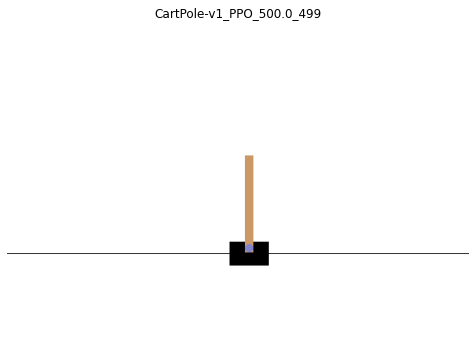

In [13]:
train(cfg)